In [19]:
import pickle
import os
import torch
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

from blur_funcs import FUNCS_GR, ACTIONS_GR, kernel1, dilig, blur
import numpy as np

SEED = 0
SAMPLE_SIZE = 1000
TEST_SIZE = 10000

In [27]:
def apply(original_set, train_funcs, c):  
    dataset = []
    for k, func in enumerate(train_funcs):
        img = original_set[k]
        det_img = img.copy()
        det_img = func(det_img, c=c)
        dataset.append(det_img)
    return np.array(dataset)


# def augument_data(source):
#     data = []
#     for c in source:
#         new = [
#             c,
#             np.rot90(c, np.random.randint(1, 4)),
#             np.fliplr(c),
#             np.flipud(c)                
#         ]
#         data.extend(new)
#     data = np.array(data, dtype=source.dtype)
#     return data


def create_train_dataset(train_funcs, c=3, fname='', seed=SEED, size=SAMPLE_SIZE):
    train_dataset = datasets.MNIST(root='../open_data/', train=True, download=True)
    np.random.seed(seed)
    idx = np.random.choice(train_dataset.data.shape[0], size)
    imgs = train_dataset.data[idx].numpy()
#     augumented_dataset = augument_data(imgs)
    originals = imgs
    originals = originals / 255

    train_dataset = apply(originals, train_funcs, c)

    np.savez(
        os.path.join('data', fname),
        train_dataset=train_dataset,
        original_dataset=originals,
    )
    

# テストデータ
def create_test_dataset(funcs, fname='', c=3):    
    np.random.seed(SEED)
    originals = datasets.MNIST(root='../open_data/', train=False, download=True).data.numpy()
    originals = originals / 255    
    
    test_dataset = apply(originals, funcs, c)
    np.savez(
        os.path.join('data', fname),
        test_dataset=test_dataset,
        original_dataset=originals,
    )

In [28]:
os.makedirs('data/GR', exist_ok=True)
os.makedirs('data/GR/test', exist_ok=True)
os.makedirs('data/GR/test/gauss', exist_ok=True)
os.makedirs('data/GR/test/random', exist_ok=True)
os.makedirs('data/GR/test/smooth', exist_ok=True)
C = 3

# Gaussだけ, C=3
funcs_gauss = [FUNCS_GR[0]] * SAMPLE_SIZE
create_train_dataset(funcs_gauss, c=C, fname='GR/train_gauss_dataset.npz')

# with random
funcs_with_random = funcs_gauss[:SAMPLE_SIZE//2] + [FUNCS_GR[1]] * (SAMPLE_SIZE//2)
create_train_dataset(funcs_gauss, c=C, fname='GR/train_with_random_dataset.npz')

# gauss
funcs_gauss = [FUNCS_GR[0]] * TEST_SIZE
create_test_dataset(funcs_gauss, c=C, fname='GR' + '/test/gauss/c3_dataset.npz')

# random
funcs_random = [FUNCS_GR[1]] * TEST_SIZE
create_test_dataset(funcs_random, c=C, fname='GR' + '/test/random/c3_dataset.npz')

# smooth
kernel3 = np.ones_like(kernel1)
kernel3 = kernel3 / kernel3.sum()
f = dilig(lambda x, c=3: blur(x, kernel3, c))
funcs_smooth = [f] * TEST_SIZE

create_test_dataset(funcs_smooth, c=C, fname='GR' + '/test/smooth/c3_dataset.npz')

### 作成したデータの確認

##### 訓練データの確認

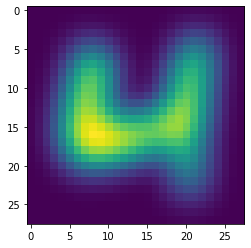

0.017006963331680686

In [29]:
train_context = np.load('data/GR/train_gauss_dataset.npz')
train_dataset = train_context['train_dataset']
tr = train_dataset[0]
plt.imshow(tr)
plt.show()

# ガウスで3回やったやつはガウスでも戻らんかい
s = 0
for t in train_dataset:
    a = t.copy()
    for _ in range(3):
        a = ACTIONS_GR[2](a)
    s += np.mean((a - t)**2)
s / len(train_dataset)

##### テストデータの確認

In [14]:
filt = 'gauss'
c = 3
TEST_DATASET_PATH = 'data/GR/test/%s/c%d_dataset.npz' % (filt, c)
test_dataset_context = np.load(TEST_DATASET_PATH)
originals = test_dataset_context['original_dataset']
test_dataset = test_dataset_context['test_dataset']
test_dataset = torch.from_numpy(test_dataset)
originals = torch.from_numpy(originals)

In [16]:
# ガウスで3回やったやつはガウスx3で戻る？
s = 0
for t in test_dataset:
    a = t.clone()
    for _ in range(3):
        a = ACTIONS_GR[2](a)
    s += torch.mean((a - t)**2).item()
s / len(test_dataset)

0.01731489976105362

0.041754009905595725
0.01403988877732478


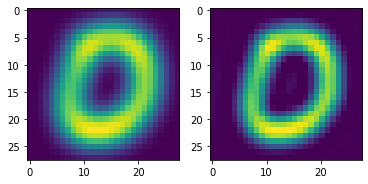

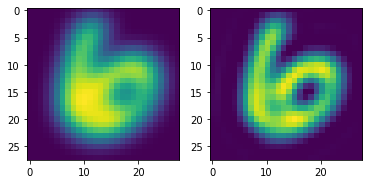

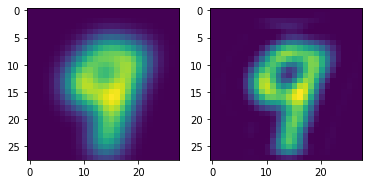

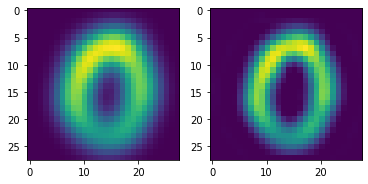

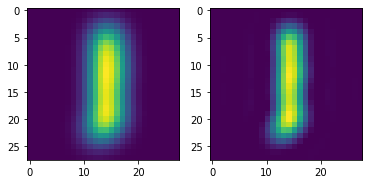

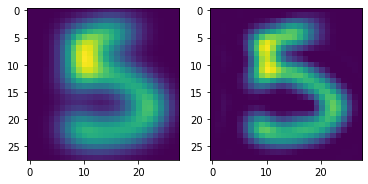

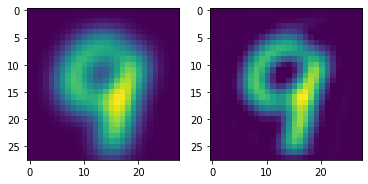

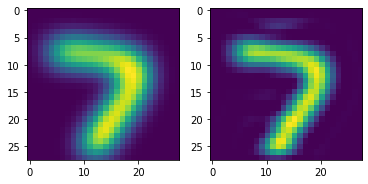

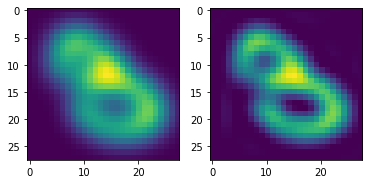

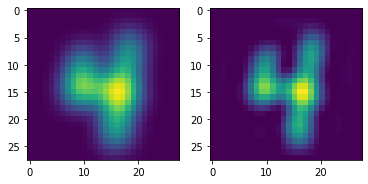

In [17]:
# TRY: MNISTのテストデータからgauss x 3 で作成したデータをgauss weiner x 3で戻る？
originals = datasets.MNIST(root='../open_data/', train=False, download=True).data.numpy()
originals = originals / 255    

# データ作成
data = []
blr_mse = 0
for i in range(originals.shape[0]):
    o = originals[i]
    blr = o.copy()
    for _ in range(3):
        blr = blur(o, kernel1, c=3)
    blr_mse += np.mean((o - blr)**2)
    data.append(blr)
print(blr_mse / originals.shape[0])
data = np.array(data)
data.shape

# テスト評価
test_mse = 0
for i in range(data.shape[0]):
    d = data[i].copy()
    for _ in range(3):
        d = ACTIONS_GR[2](d)
    o = originals[i]
    test_mse += np.mean((d - o)**2)
print(test_mse / data.shape[0])

for i in range(10, 20):
    d = data[i].copy()
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(d)
    for _ in range(2):
        d = ACTIONS_GR[2](d)
    axes[1].imshow(d)
    plt.show()

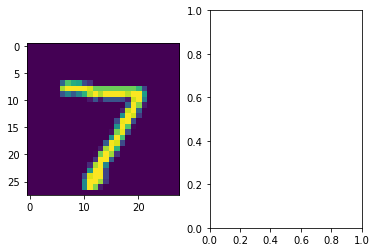

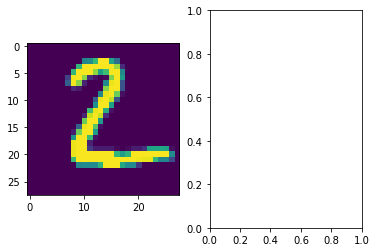

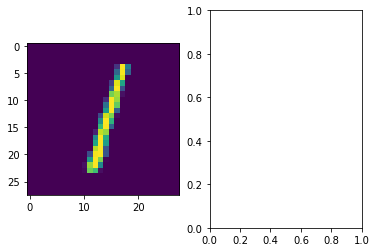

In [37]:
for i in range(3):
    o = originals[i]
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(o)
    plt.show()